# Predict Ethereum Close Price with Prophet

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [4]:
def plot(y_pred, y_true, times=100):
    sns.set_style("darkgrid")
    plt.plot(y_true[:times], color='green',label="True")        
    plt.plot(y_pred[:times], color='blue', label="Prediction")
    plt.legend()
    plt.show()

## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

In [7]:
pu.get_device()

device(type='cuda', index=0)

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.__version__

'1.11.0'

In [10]:
sns.set(rc = {'figure.figsize':(15,8)})

In [11]:
DATASET_PATH = '../datasets/ETH_1H.csv'

## Preprocessing

In [38]:
def preprocessing(dataset, column):
    dataset.columns = dataset.columns.str.lower()
    dataset.columns
    dataset       = dataset[['date', column]]
    dataset       = dataset.rename(columns={'date': 'ds', column: 'y' })
    dataset['ds'] = pd.to_datetime(dataset['ds'])
    dataset       = dataset.sort_values(by='ds',ascending=True)
    
    train_set, test_set           = train_test_split(dataset, test_percent = 0.1)
    norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=['y'])

    norm_train_set = norm_train_set[['ds', 'norm_y']]
    norm_train_set = norm_train_set.rename(columns={'norm_y': 'y' })


    return norm_train_set, norm_test_set

In [39]:
dataset = pd.read_csv(DATASET_PATH)

train_set, test_set = preprocessing(dataset, 'close')

train_set.info()
train_set.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450 entries, 34496 to 31047
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3450 non-null   datetime64[ns]
 1   y       3450 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 80.9 KB


,ds,y
34496,2016-05-09 13:00:00,-1.736967
34495,2016-05-09 14:00:00,-1.467009
34494,2016-05-09 15:00:00,-1.473008
34493,2016-05-09 16:00:00,-1.568993
34492,2016-05-09 17:00:00,-1.772962


# Model Definition

In [40]:
model = Prophet(
    interval_width=0.95, 
    daily_seasonality=True
)

In [41]:
model.fit(norm_train_set)

2022-08-14 16:44:27,658 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-08-14 16:44:27,667 - DEBUG - input tempfile: /var/tmp/tmpaxxedek0/obnyfy25.json
2022-08-14 16:44:27,733 - DEBUG - input tempfile: /var/tmp/tmpaxxedek0/5xgce_dj.json
2022-08-14 16:44:27,734 - DEBUG - idx 0
2022-08-14 16:44:27,734 - DEBUG - running CmdStan, num_threads: None
2022-08-14 16:44:27,734 - DEBUG - CmdStan args: ['/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25509', 'data', 'file=/var/tmp/tmpaxxedek0/obnyfy25.json', 'init=/var/tmp/tmpaxxedek0/5xgce_dj.json', 'output', 'file=/var/tmp/tmp7_iekqzb/prophet_model-20220814164427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:44:27 - cmdstanpy - INFO - Chain [1] start processing
2022-08-14 16:44:27,734 - INFO - Chain [1] start processing
16:44:28 - cmdstanpy - INFO - Chain [1] done processing
2022-08-14 16:44:28,002 - INF

<prophet.forecaster.Prophet object at 0x7f9a782725f0>

In [43]:
test_set_dates = norm_test_set[['ds']].sort_values(by='ds',ascending=True)
test_set_dates.head()

,ds
31047,2016-09-30 06:00:00
31046,2016-09-30 07:00:00
31045,2016-09-30 08:00:00
31044,2016-09-30 09:00:00
31043,2016-09-30 10:00:00


In [44]:
forecast = model.predict(test_set_dates)

In [45]:
results = norm_test_set.merge(forecast, on='ds')

In [46]:
results = results[['ds', 'norm_y', 'yhat', 'yhat_lower', 'yhat_upper']].sort_values(by='ds',ascending=True)
results.head()

,ds,norm_y,yhat,yhat_lower,yhat_upper
0,2016-09-30 06:00:00,0.470695,0.726980,-0.391349,1.986851
1,2016-09-30 07:00:00,0.416703,0.714377,-0.405165,1.871803
2,2016-09-30 08:00:00,0.416703,0.696779,-0.455770,1.886906
3,2016-09-30 09:00:00,0.416703,0.679766,-0.469804,1.875335
4,2016-09-30 10:00:00,0.416703,0.668941,-0.461775,1.880320


In [47]:
def plot(y_pred, y_true, times=100):
    sns.set_style("darkgrid")
    plt.plot(y_true[:times], color='green',label="True")        
    plt.plot(y_pred[:times], color='blue', label="Prediction")
    plt.legend()
    plt.show()

<Figure size 1080x576 with 1 Axes>

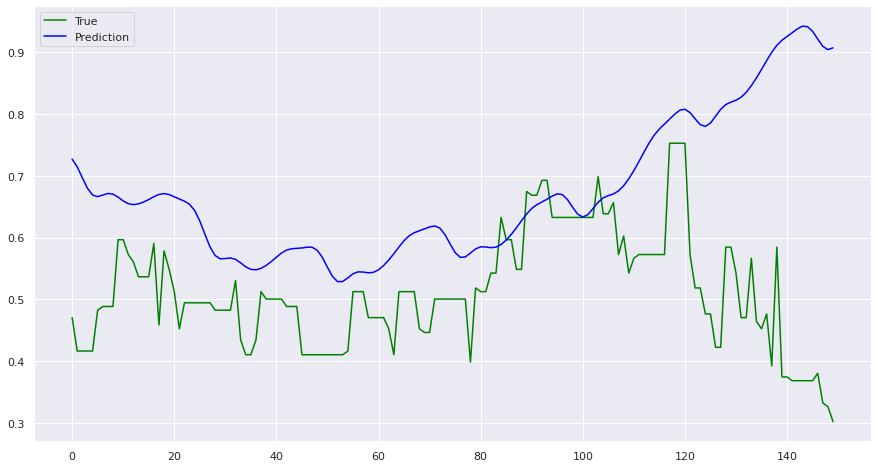

In [48]:
plot(results.yhat.values, results.norm_y.values, times=150)